# Introduction to Data Science – Lecture 12 - APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for **A**pplication **P**rogramming **I**nterface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
An API works a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs, REST (REpresentational State Transfer), which are now the dominant way of exposing and API on the web. REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```

REST APIs can return data in different forms, the most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response and it has status 200. What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"timestamp": 1518671239, "iss_position": {"longitude": "14.9127", "latitude": "-32.1697"}, "message": "success"}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"timestamp": 1518671239, "iss_position": {"longitude": "14.9127", "latitude": "-32.1697"}, "message": "success"}


Let's take a look at the JSON here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'timestamp': 1518671239, 'iss_position': {'longitude': '14.9127', 'latitude': '-32.1697'}, 'message': 'success'}


{'latitude': '-32.1697', 'longitude': '14.9127'}

Or, not surprisingly, pandas can also load a jsong object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,iss_position,message,timestamp
latitude,-32.1697,success,2018-02-15 05:07:19
longitude,14.9127,success,2018-02-15 05:07:19


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_d["latitude"] = response_d["iss_position"]["latitude"]
    response_d["longitude"] = response_d["iss_position"]["longitude"]
    del(response_d["iss_position"])
    return response_d
flatten(response_d)

{'latitude': '-32.1697',
 'longitude': '14.9127',
 'message': 'success',
 'timestamp': 1518671239}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'timestamp': 1518671240, 'message': 'success', 'latitude': '-32.1256', 'longitude': '14.9646'}
{'timestamp': 1518671243, 'message': 'success', 'latitude': '-31.9932', 'longitude': '15.1201'}
{'timestamp': 1518671246, 'message': 'success', 'latitude': '-31.8607', 'longitude': '15.2749'}
{'timestamp': 1518671250, 'message': 'success', 'latitude': '-31.7057', 'longitude': '15.4551'}
{'timestamp': 1518671253, 'message': 'success', 'latitude': '-31.5726', 'longitude': '15.6090'}
{'timestamp': 1518671256, 'message': 'success', 'latitude': '-31.4393', 'longitude': '15.7624'}
{'timestamp': 1518671259, 'message': 'success', 'latitude': '-31.3057', 'longitude': '15.9153'}
{'timestamp': 1518671262, 'message': 'success', 'latitude': '-31.1720', 'longitude': '16.0678'}
{'timestamp': 1518671265, 'message': 'success', 'latitude': '-31.0380', 'longitude': '16.2198'}
{'timestamp': 1518671268, 'message': 'success', 'latitude': '-30.8815', 'longitude': '16.3966'}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)

Let's see how the ISS moves

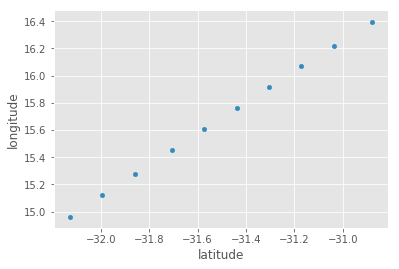

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [12]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1518667882,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 408, 'risetime': 1518711214},
  {'duration': 635, 'risetime': 1518716849},
  {'duration': 604, 'risetime': 1518722666},
  {'duration': 545, 'risetime': 1518728538},
  {'duration': 586, 'risetime': 1518734366}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2018-02-15 16:13:34')

So, the ISS will be visible at 4:13:34!

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJTrump.com',
       'expanded_url': 'http://www.DonaldJTrump.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. Trump',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldTrump',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [14]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
from credentials_alex import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [15]:
tag = "#resist"
result = twitter.search(q=tag, tweet_mode="extended")
result

{'search_metadata': {'completed_in': 0.054,
  'count': 15,
  'max_id': 964003239401349120,
  'max_id_str': '964003239401349120',
  'next_results': '?max_id=964003033628672001&q=%23resist&include_entities=1',
  'query': '%23resist',
  'refresh_url': '?since_id=964003239401349120&q=%23resist&include_entities=1',
  'since_id': 0,
  'since_id_str': '0'},
 'statuses': [{'contributors': None,
   'coordinates': None,
   'created_at': 'Thu Feb 15 05:07:37 +0000 2018',
   'display_text_range': [0, 143],
   'entities': {'hashtags': [{'indices': [107, 117], 'text': 'VOLUNTEER'},
     {'indices': [118, 125], 'text': 'DONATE'},
     {'indices': [126, 134], 'text': 'RECRUIT'},
     {'indices': [135, 142], 'text': 'RESIST'}],
    'symbols': [],
    'urls': [],
    'user_mentions': [{'id': 119360780,
      'id_str': '119360780',
      'indices': [3, 15],
      'name': 'Stella M S',
      'screen_name': '24CarlyS119'},
     {'id': 14173315,
      'id_str': '14173315',
      'indices': [17, 25],
      '

The result is an array of tweets, we can look at specific text:

In [16]:
result["statuses"][0]["full_text"]

"RT @24CarlyS119: @NBCNews THE GOP &amp; NRA AREN'T ALL THAT'S WRONG.  PEOPLE WHO DO NOTHING ARE NOW WORSE. #VOLUNTEER #DONATE #RECRUIT #RESIST…"

Or print all the tweets:

In [17]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @24CarlyS119: @NBCNews THE GOP &amp; NRA AREN'T ALL THAT'S WRONG.  PEOPLE WHO DO NOTHING ARE NOW WORSE. #VOLUNTEER #DONATE #RECRUIT #RESIST…
----
We are all wrestling with these compounding tragedies &amp; the emotional strain as they tear at our souls
In these times as in the dark days before we need the voices that calm educate &amp; lift us. You @sherilynch &amp; yours are those voices.
#Resist
----
At 19, Nikolas is an adult who could purchase his weapons legally. Where he got the money to do so has yet to be disclosed. One rumor states that he was bullied in school. Aha!
#trump #maga #potus #gop #dems #IngrahamAngle #wattersworld #resist #TuckerCarlsonTonight #SeanHannity
----
RT @progresslabsorg: Now Just Five Men Own Almost as Much Wealth as Half the World's Population https://t.co/1Jn0V1YYwo #resist #fbr
----
'I invite him to get off his ass': Dem Congressman slams Trump in wake of another school shooting 
https://t.co/xI96RDZk1B
#GOPCorruptAF  #LGBT #LGBTQ #Resist #TheResis

We can also search for tweets based on usernames:

In [18]:
result = twitter.search(q="@realDonaldTrump",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @realDonaldTrump: As we come together to celebrate the extraordinary contributions of African-Americans to our nation, our thoughts turn…
----
RT @BGibbles: @realDonaldTrump Your prayers and condolences won’t do shit to prevent this from happening more in the future. Use your power…
----
RT @SarahBoothHenry: @realDonaldTrump ....then do something about it! 18 worldwide in 2 decades. 18 in the US in 35 days. DO SOMETHING!
----
RT @MaggieJordanACN: . @realDonaldTrump received $31,194,646 from the NRA in 2016 https://t.co/qSBSp9U9MD
----
@icegov Excellent. Keep up God's Work. He too has a wall that only certain people can enter. 
@FrantzRadio @WayneDupreeShow @realDonaldTrump @Scavino45 @PressSec @WhiteHouse @mike_pence @VP @SpeakerRyan @SenMajLdr https://t.co/ltkg9Syz0o
----
@FalconsKingdom @christy_doyon @Tnlady56King @realDonaldTrump In special cases, security can carry one around.
----
RT @timmYTiggerG13: @realDonaldTrump U r not doing anyx.  What Abt law enforcement?? The kid is i

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download The Donald's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [19]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
the_donald_result = twitter.get_user_timeline(screen_name="realDonaldTrump", count=50)
the_donald_result

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Wed Feb 14 20:55:01 +0000 2018',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 76290,
  'favorited': False,
  'geo': None,
  'id': 963879275324760070,
  'id_str': '963879275324760070',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 14865,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'text': 'Just spoke to Governor Rick Scott. We are working closely with law enforcement on the terrible Florida school shooting.',
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'des

Let's count the numbers for The Donald's favorites and retweets.

In [20]:
the_donald_favorites = []
the_donald_retweets = []
for status in the_donald_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    the_donald_favorites.append(status["favorite_count"])
    the_donald_retweets.append(status["retweet_count"])

Just spoke to Governor Rick Scott. We are working closely with law enforcement on the terrible Florida school shooting.
76290
----
My prayers and condolences to the families of the victims of the terrible Florida shooting. No child, teacher or an… https://t.co/RFJxgM1jhm
116218
----
Today, I was honored to be joined by Republicans and Democrats from both the House and Senate, as well as members o… https://t.co/38kUIIV8Cp
38193
----
As we come together to celebrate the extraordinary contributions of African-Americans to our nation, our thoughts t… https://t.co/SwAJxO88zC
47068
----
Negotiations on DACA have begun. Republicans want to make a deal and Democrats say they want to make a deal. Wouldn… https://t.co/YW4mCpHr0R
89413
----
Our infrastructure plan has been put forward and has received great reviews by everyone except, of course, the Demo… https://t.co/2EfB9sObdN
98910
----
The journey to #MAGA began @CPAC 2011 and the opportunity to reconnect with friends and supporters is someth

Now let's do the same for Hillary.

In [21]:
hillary_results = twitter.get_user_timeline(screen_name="HillaryClinton", count=50)
hillary_results

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Thu Feb 15 03:58:59 +0000 2018',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [{'display_url': 'giffords.org/2018/02/florid…',
     'expanded_url': 'https://giffords.org/2018/02/floridaschool/',
     'indices': [104, 127],
     'url': 'https://t.co/78PglvHbTO'}],
   'user_mentions': [{'id': 587536673,
     'id_str': '587536673',
     'indices': [3, 19],
     'name': 'Giffords',
     'screen_name': 'GiffordsCourage'},
    {'id': 44177383,
     'id_str': '44177383',
     'indices': [26, 40],
     'name': 'Gabrielle Giffords',
     'screen_name': 'GabbyGiffords'}]},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 963985969576890368,
  'id_str': '963985969576890368',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': Non

In [22]:
hillary_favorites = []
hillary_retweets = []
for status in hillary_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    hillary_favorites.append(status["favorite_count"])
    hillary_retweets.append(status["retweet_count"])

RT @GiffordsCourage: Read @GabbyGiffords' statement about today's school shooting in Parkland, Florida: https://t.co/78PglvHbTO
0
----
Love this! https://t.co/8wMSuoQa34
27800
----
Tune in today at 2:30pm ET/11:30am PT! https://t.co/rnrRfjlsAI
9421
----
A new book is out today that picks up where I left off in What Happened in explaining “Those Damn Emails.” Terrific… https://t.co/gWO6S0OXuO
22572
----
25 years ago, @billclinton signed the Family and Medical Leave Act, which remains a success all these years later.… https://t.co/hYGHBixDNB
38978
----
Looking forward to being a part of #MAKERSConference2018 and talking about how we can all raise our voices.  Watch… https://t.co/ep1R2ldDHU
9468
----
Tune in! https://t.co/8OP5wp7gwa
11524
----
@PhilippeReines @RWPUSA @ErinBurnett @CNN 🙏
1638
----
I wrote a Facebook post about a decision I made 10 years ago, what’s changed, &amp; on an issue you didn’t hear a singl… https://t.co/g26PP5U8qJ
51886
----
I called her today to tell her how prou

And let's create DataFrames for both of them and explore their stats:

In [23]:
donald_stats = pd.DataFrame({
        "The Donald Fav":the_donald_favorites,
        "The Donald RT":the_donald_retweets
    })

hillary_stats = pd.DataFrame({
      "Hillary Fav":hillary_favorites,
      "Hillary RT":hillary_retweets
        })

In [24]:
donald_stats.head()

,The Donald Fav,The Donald RT
0,76290,14865
1,116218,29214
2,38193,8305
3,47068,11608
4,89413,20304


In [25]:
donald_stats.describe()

,The Donald Fav,The Donald RT
count,50.000000,50.000000
mean,106076.680000,25211.900000
std,32154.470329,8388.103768
min,38193.000000,8305.000000
25%,84526.750000,19978.500000
50%,105715.500000,24412.500000
75%,121180.000000,30821.250000
max,212218.000000,43296.000000


In [26]:
hillary_stats.describe()

,Hillary Fav,Hillary RT
count,50.000000,50.00000
mean,44183.320000,14050.46000
std,79341.301204,31064.57244
min,0.000000,200.00000
25%,5475.250000,1541.00000
50%,19502.000000,4417.50000
75%,44391.000000,10332.75000
max,455044.000000,194749.00000


Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [27]:
donald_stats = donald_stats.sort_values("The Donald Fav")
donald_stats = donald_stats.reset_index(drop=True)
donald_stats.head()

,The Donald Fav,The Donald RT
0,38193,8305
1,47068,11608
2,63319,13725
3,63652,13793
4,64716,12768


In [28]:
hillary_stats = hillary_stats.sort_values("Hillary Fav")
hillary_stats = hillary_stats.reset_index(drop=True)
hillary_stats.head(15)

,Hillary Fav,Hillary RT
0,0,479
1,0,946
2,0,1044
3,0,194749
4,0,725
5,0,4088
6,0,45704
7,781,200
8,1638,343
9,1923,508


In [29]:
combined = hillary_stats.copy()
combined["The Donald Fav"] = donald_stats["The Donald Fav"]
combined["The Donald RT"] = donald_stats["The Donald RT"]

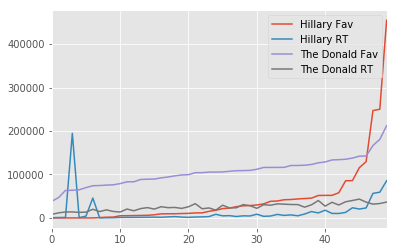

In [30]:
combined.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.